# A Simple Statistical Model for Picking Most Abundant Sequences

by Eric J. Ma and Arkadij Kummer



## Introduction

In DNA sequencing, when we look at the raw sequencing data, we might see that a sample contains a multiple of sequences, each with different read counts. If we are to use this data in machine learning, one modelling choice we usually need make is to pick one of those sequences as the representative one, or else omit the data from our downstream model if we deem it to be of insufficient quality.

By insufficient quality, we usually refer to one of the following scenarios:

1. Low read counts.
1. Mixture of sequences with very similar read counts.
1. Both of the above.

A common practice in the DNA sequencing world is to pick a threshold (e.g. discard everything with less than 10 read counts). We wondered whether there might be a statistically-principled way for us to identify for which samples we could "just pick the highest value", and for which samples we need to omit from downstream ML purposes.

## Example DNA Sequencing Data

As an example, we may have sequencing data that look like the following:

| Sequence | Count |
|----------|-------|
| AGGAT... |  17   |
| AGGTT... |  3    |
| ACGAT... |  121  |

This data can be cast in an ["urn problem"](https://en.m.wikipedia.org/wiki/Urn_problem). From a generative model standpoint, we consider sequences to be present at a range of proportions in an urn, and the DNA sequencer samples them, giving rise to the read count data that we observe. The number of categories (i.e. unique sequences) varies per urn (i.e. a DNA sample sent for sequencing). An appropriate statistical model here for each DNA sample is the Dirichlet-Multinomial model, which has a number of nice properties that we can take advantage of:

1. The multinomial distribution story gives sample counts from groups of data.
1. The Dirichlet distribution is the conjugate prior for the multinomial distribution probability parameter $p$, meaning that simple addition arithmetic can be used to compute the Dirichlet posterior.
1. Dirichlet distribution marginals for any of the categories is Beta-distributed, which is also analytically computable.

Before we go on to the problem, let's take a very quick and cursory look that powers this, just as a reminder.

## Dirichlet-Multinomial Bayesian Updating

Very briefly, if we have the following prior distribution

$$p_prior \sim Dir([\alpha_1, \alpha_2, ..., \alpha_n])$$

which models the probability of observing each of $n$ groups, and we observe actual counts for the $n$ groups

$$c = [c_1, c_2, ..., c_n]$$

Then the posterior distribution of the $\alpha$s is 

$$p_{posterior} \sim Dir([\alpha_1 + c_1, \alpha_2 + c_2, ..., \alpha_n + c_n])$$

Moreover, the marginal distribution of each of the probabilities $1, 2, ... n$ is given by a Beta distribution

$$p_{n} \sim Beta(\alpha_n + c_n, \sum_{i≠n}(\alpha_i + c_i))$$

Taking advantage of conjugacy means we can avoid doing MCMC, and simply turn to arithmetic instead.

Here are a few examples of posterior updating with a prior distribution.

In [1]:
from scipy.stats import dirichlet, multinomial, beta
import numpy as np

In [2]:
import matplotlib.pyplot as plt


def plot_posterior(read_counts):
    xs = np.linspace(0, 1, 1000)

    prior_counts = np.ones(len(read_counts))
    posterior_counts = prior_counts + read_counts

    for count in posterior_counts:
        marginal = beta(count, posterior_counts.sum() - count).pdf(xs)
        plt.plot(xs, marginal, label=int(count))
    plt.xlim(-0.05, 1.05)
    plt.legend()

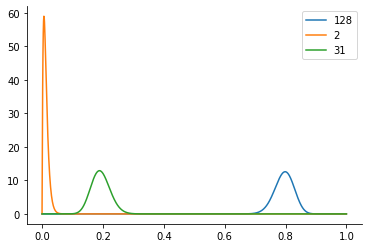

In [3]:
plot_posterior([127, 1, 30])

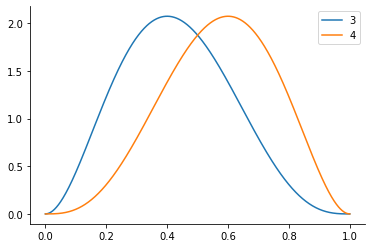

In [4]:
plot_posterior([2, 3])

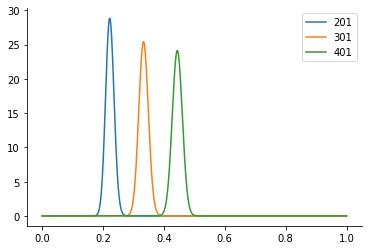

In [5]:
plot_posterior([200, 300, 400])

How might we devise a rule for whether or not to pick the top sequence?

We could look at a particular percentage interval of the posterior distribution of the top count, and ask if it overlaps with the rest of the posterior distributions on the same percentage interval.

For example, let's see if the 99% interval of the $[2, 3]$ scenario overlaps (if it's not obvious from above, it should).

In [6]:
def kth_largest(a, k):
    return np.sort(a)[-k]


def keep_largest_test(read_counts):

    prior_counts = np.ones(len(read_counts))
    posterior_counts = prior_counts + read_counts

    max1 = kth_largest(posterior_counts, 1)
    max2 = kth_largest(posterior_counts, 2)

    max1dist = beta(max1, sum(posterior_counts) - max1)
    max2dist = beta(max2, sum(posterior_counts) - max2)
    quantiles = [0.025, 0.975]

    max1l, max1u = max1dist.ppf(quantiles)
    max2l, max2u = max2dist.ppf(quantiles)

    if max1l > max2u:
        return True
    else:
        return False

In [7]:
keep_largest_test([200, 300, 400])

True